In [1]:
import time
from os.path import join

import numpy as np
import cv2
import torch
import torch.nn as nn
from torchvision.models import resnet101

from yolort.models.yolo import YOLO
from yolort.utils import Visualizer
from yolort.v5 import load_yolov5_model, non_max_suppression

In [11]:
# configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_cuda = False if str(device) == "cpu" else True

models_bcls = "/home/ajvalenc/OneDrive - University of Ottawa/Projects/spectronix/thermal/Cpp_Codes/models/Blood_Classification_resnet101.pth"
models_bdet = "/home/ajvalenc/OneDrive - University of Ottawa/Projects/spectronix/thermal/Cpp_Codes/models/Blood_Detection_Yolov5.pt"
models_fdet = "/home/ajvalenc/OneDrive - University of Ottawa/Projects/spectronix/thermal/Cpp_Codes/models/Face_Detection_Yolov5.pt"

In [12]:
# load model parameters
score_thresh = 0.20
nms_thresh = 0.45

In [13]:
# load models
model_bcls = torch.load(models_bcls, map_location=device)

model_bdet = YOLO.load_from_yolov5(models_bdet, score_thresh, nms_thresh)
model_bdet = model_bdet.eval()
model_bdet = model_bdet.to(device)

model_fdet = YOLO.load_from_yolov5(models_fdet, score_thresh, nms_thresh)
model_fdet = model_fdet.eval()
model_fdet = model_fdet.to(device)

In [27]:
#show class names (need to load original yolo model
yolov5_bdet = load_yolov5_model(models_bdet, fuse=True)
yolov5_fdet = load_yolov5_model(models_fdet, fuse=True)

classes_bdet = yolov5_bdet.names
classes_fdet = yolov5_fdet.names

Fusing layers... 
Model Summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
Fusing layers... 
Model Summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs


In [38]:
# input data and transform (using opencv)
filename = "/home/ajvalenc/Datasets/spectronix/thermal/BinClass_Test/Pos/T_IM_45.png"
img = cv2.imread(filename) #input

img = torch.as_tensor(img.astype("float32").transpose(2,0,1)).to(device)
img /= 255.
img = img.unsqueeze(0)

In [16]:
# dry run
for i in range(5):
    model_bcls(img)
    model_bdet(img)
    model_fdet(img)

In [20]:
with torch.no_grad(): #ensures autograd is off
    # evaluate classifier
    start = time.time()
    out_bcls = model_bcls(img)
    end = time.time()
    print("Blood classification runtime [ms]: ", 1000*(end-start))

    start = time.time()
    out_bdet = model_bdet(img)
    end = time.time()
    print("Blood detection runtime [ms]: ", 1000*(end-start))

    start = time.time()
    out_fdet = model_fdet(img)
    end = time.time()
    print("Face detection runtime [ms]: ", 1000*(end-start))

Blood classification runtime [ms]:  882.8604221343994
Blood detection runtime [ms]:  138.5324001312256
Face detection runtime [ms]:  196.20490074157715


In [21]:
print("Output bdet:", out_bdet[0])
print("Output fdet:", out_fdet[0])

Output bdet: {'scores': tensor([0.54667, 0.54289, 0.43520]), 'labels': tensor([0, 0, 1]), 'boxes': tensor([[305.09998, 256.44388, 390.91913, 334.18600],
        [253.71140, 282.03439, 272.27829, 303.39835],
        [204.28300, 307.78754, 214.77779, 320.97644]])}
Output fdet: {'scores': tensor([0.85518, 0.65909]), 'labels': tensor([0, 1]), 'boxes': tensor([[131.80284,  59.93649, 180.86443, 117.50941],
        [155.98619,  71.70175, 172.69487,  79.96494]])}


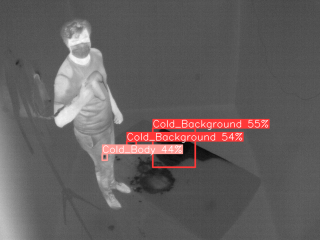

In [44]:
# verify results
img_raw = cv2.imread(filename) #original
v = Visualizer(img_raw, list(classes_bdet.values()))
v.draw_instance_predictions(out_bdet[0])
v.imshow(scale=0.5)

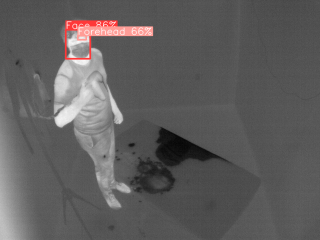

In [42]:
# verify results
img_raw = cv2.imread(filename) #original
v = Visualizer(img_raw, list(classes_fdet.values()))
v.draw_instance_predictions(out_fdet[0])
v.imshow(scale=0.5)